Resource link <br>
https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial/notebook

In [97]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import chardet
import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
from gensim.models.phrases import Phrases, Phraser

logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [98]:
## getting the encoding of file, encoding resides in result dict
with open("simpsons_dataset.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))

df = pd.read_csv('simpsons_dataset.csv', sep=',', encoding=result.get('encoding'))
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [99]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [101]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [102]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [104]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [105]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.37 mins


In [106]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85964, 1)

In [111]:
sent = [row.split() for row in df_clean['clean']]

In [112]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 16:36:26: collecting all words and their counts
INFO - 16:36:26: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 16:36:26: PROGRESS: at sentence #10000, processed 63561 words and 52816 word types
INFO - 16:36:26: PROGRESS: at sentence #20000, processed 130943 words and 99866 word types
INFO - 16:36:26: PROGRESS: at sentence #30000, processed 192972 words and 138532 word types
INFO - 16:36:26: PROGRESS: at sentence #40000, processed 249842 words and 172659 word types
INFO - 16:36:26: PROGRESS: at sentence #50000, processed 311265 words and 208566 word types
INFO - 16:36:26: PROGRESS: at sentence #60000, processed 373588 words and 243702 word types
INFO - 16:36:26: PROGRESS: at sentence #70000, processed 436441 words and 278740 word types
INFO - 16:36:27: PROGRESS: at sentence #80000, processed 497829 words and 311886 word types
INFO - 16:36:27: collected 330804 word types from a corpus of 537160 words (unigram + bigrams) and 85964 sentences
INFO - 16:36:27: us

In [114]:
bigram = Phraser(phrases)
sentences = bigram[sent]


INFO - 16:36:49: source_vocab length 330804
INFO - 16:36:52: Phraser built with 126 phrasegrams


In [138]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

30178

In [139]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'right', 'look', 'want', 'come']

In [141]:
import multiprocessing
from gensim.models import Word2Vec

cores = multiprocessing.cpu_count()
cores

8

In [65]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [66]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 14:40:54: collecting all words and their counts
INFO - 14:40:54: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 14:40:54: PROGRESS: at sentence #10000, processed 61718 words, keeping 9558 word types
INFO - 14:40:54: PROGRESS: at sentence #20000, processed 127351 words, keeping 14506 word types
INFO - 14:40:55: PROGRESS: at sentence #30000, processed 187829 words, keeping 17619 word types
INFO - 14:40:55: PROGRESS: at sentence #40000, processed 243332 words, keeping 20385 word types
INFO - 14:40:55: PROGRESS: at sentence #50000, processed 303182 words, keeping 22878 word types
INFO - 14:40:55: PROGRESS: at sentence #60000, processed 363940 words, keeping 25200 word types
INFO - 14:40:55: PROGRESS: at sentence #70000, processed 425408 words, keeping 27401 word types
INFO - 14:40:55: PROGRESS: at sentence #80000, processed 485464 words, keeping 29275 word types
INFO - 14:40:55: collected 30178 word types from a corpus of 523700 raw words and 85964 sentence

In [67]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

; awaiting finish of 6 more threads
INFO - 14:41:22: worker thread finished; awaiting finish of 5 more threads
INFO - 14:41:22: worker thread finished; awaiting finish of 4 more threads
INFO - 14:41:22: worker thread finished; awaiting finish of 3 more threads
INFO - 14:41:22: worker thread finished; awaiting finish of 2 more threads
INFO - 14:41:22: worker thread finished; awaiting finish of 1 more threads
INFO - 14:41:22: worker thread finished; awaiting finish of 0 more threads
INFO - 14:41:22: EPOCH - 6 : training on 523700 raw words (199375 effective words) took 1.9s, 107530 effective words/s
INFO - 14:41:23: EPOCH 7 - PROGRESS: at 55.67% examples, 108520 words/s, in_qsize 0, out_qsize 0
INFO - 14:41:24: worker thread finished; awaiting finish of 6 more threads
INFO - 14:41:24: worker thread finished; awaiting finish of 5 more threads
INFO - 14:41:24: worker thread finished; awaiting finish of 4 more threads
INFO - 14:41:24: worker thread finished; awaiting finish of 3 more thread

In [70]:
w2v_model.init_sims(replace=True)

INFO - 14:44:19: precomputing L2-norms of word weight vectors


In [71]:
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.8078569173812866),
 ('sweetheart', 0.7834697961807251),
 ('bongo', 0.7597969770431519),
 ('snuggle', 0.7565881013870239),
 ('worry', 0.7460476756095886),
 ('maybe', 0.7460201978683472),
 ('hammock', 0.7434959411621094),
 ('straighten', 0.7416648864746094),
 ('rude', 0.7396849393844604),
 ('awww', 0.7361342906951904)]

In [72]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('congratulation', 0.8001703023910522),
 ('easily', 0.7750089168548584),
 ('request', 0.7732250690460205),
 ('respond', 0.7724166512489319),
 ('select', 0.7664061784744263),
 ('charles', 0.7653089165687561),
 ('fellow', 0.7604631185531616),
 ('robert', 0.7602878212928772),
 ('governor', 0.7589755654335022),
 ('pleased', 0.7586044073104858)]

In [73]:
w2v_model.wv.most_similar(positive=["marge"])

[('homer', 0.8078570365905762),
 ('loving', 0.7634598016738892),
 ('sorry', 0.7619024515151978),
 ('arrange', 0.754332423210144),
 ('vegas', 0.7485796213150024),
 ('becky', 0.7443729043006897),
 ('snuggle', 0.7421844005584717),
 ('fault', 0.741607129573822),
 ('ashamed', 0.7383641600608826),
 ('spoil', 0.7383559346199036)]

In [74]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.8658926486968994),
 ('homework', 0.7963451147079468),
 ('mom', 0.7930448055267334),
 ('janey', 0.7823795080184937),
 ('bedtime', 0.7807885408401489),
 ('jealous', 0.7728176712989807),
 ('grownup', 0.7693604826927185),
 ('mom_dad', 0.767346203327179),
 ('maggie', 0.7634708881378174),
 ('surprised', 0.760744035243988)]

In [76]:
w2v_model.wv.similarity('maggie', 'baby')

0.7089961

In [77]:
w2v_model.wv.similarity('bart', 'nelson')

0.6454393

In [78]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

WARNING - 14:44:58: vectors for words {'kearney'} are not present in the model, ignoring these words


'milhouse'

In [79]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

In [80]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

'homer'

In [81]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('admire', 0.6893293857574463),
 ('man', 0.657768189907074),
 ('wealthy', 0.6516662836074829)]

In [82]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('lisa', 0.7635124921798706),
 ('pregnant', 0.7051354646682739),
 ('daughter', 0.6879599094390869)]

In [83]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [89]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

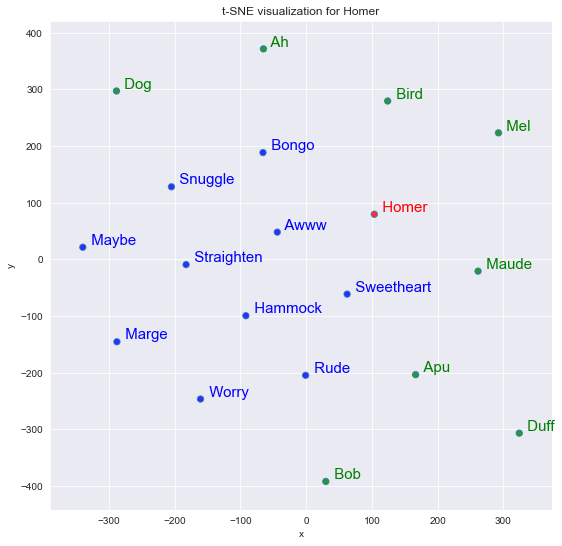

In [90]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

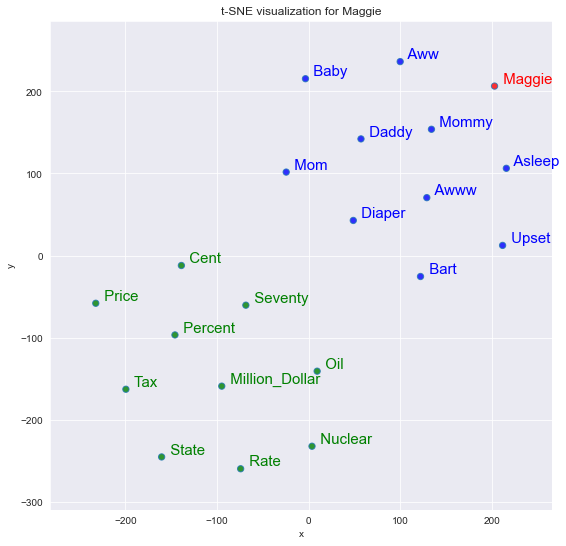

In [91]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

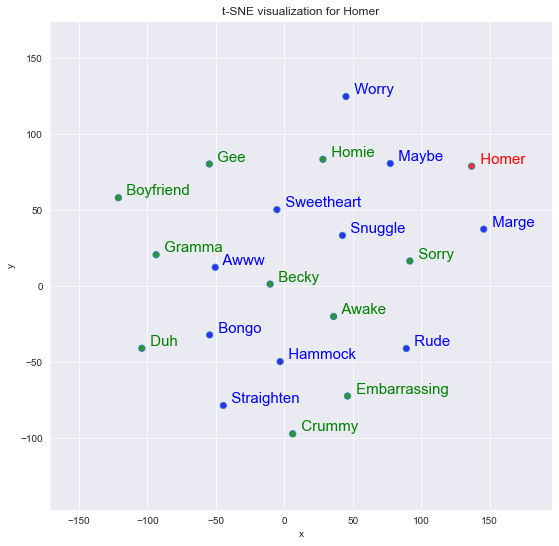

In [94]:
tsnescatterplot(w2v_model, "homer", [t[0] for t in w2v_model.wv.most_similar(positive=["homer"], topn=20)][10:])